In [2]:
#getting rid of warnings
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
sys.stderr = open(os.devnull, 'w')
import tensorflow as tf
logger = tf.get_logger().setLevel("ERROR") #

2025-06-11 18:14:15.126430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749665655.142106   13092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749665655.147051   13092 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749665655.159415   13092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749665655.159432   13092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749665655.159434   13092 computation_placer.cc:177] computation placer alr

In [3]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from keras import ops
from keras.layers import StringLookup
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import json
from tqdm import tqdm
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

In [4]:
# Check if GPU is available test
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices:
    print("No GPU detected.")
else:
    print("GPU detected:", physical_devices)


GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
dataPath = "../trainingData/" #FILEPATH



--- words.txt ---------------------------------------------------------------#

 iam database word information

 format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

     a01-000u-00-00  -> word id for line 00 in form a01-000u
     ok              -> result of word segmentation
                            ok: word was correctly
                            er: segmentation of word can be bad

     154             -> graylevel to binarize the line containing this word
     1               -> number of components for this word NOTE: dont think this exists idk why
     408 768 27 51   -> bounding box around this word in x,y,w,h format
     AT              -> the grammatical tag for this word, see the
                        file tagset.txt for an explanation
     A               -> the transcription for this word


In [6]:
%%time
#imports all the file paths into a 
try:
    with open ("imagePaths.json","r") as j:
        images = json.load(j)
except:
    open("imagePaths.json","w").close()
    text = open(dataPath + "ascii/words.txt","r").read().splitlines()
    text = text[18:] #first 18 lines is metadata
    images = []
    for data in text:
        parts = data.split(" ")
        word = parts[-1]
        tmp = parts[0].split("-")
        path = dataPath + "augmentedWords/IAM/" + tmp[0]+"/"+tmp[0]+"-"+tmp[1]+"/"+parts[0]+"/"
        if len(word) == 1:
            inDir = os.listdir(path)
            for f in inDir:
                images.append([os.path.join(path+f), word]) #last 2 are width and height ord() to convert to ascii

    def recurSearch (path,letter):
        files = os.listdir(path)
        if files[0][:5] == "image":
            for f in files:
                images.append([os.path.join(path,f), letter])
        else:
            for f in files:
                recurSearch(os.path.join(path,f), letter)
              

    letters = os.listdir(dataPath + "augmentedWords/EMNIST/")
    print (letters)
    print ([chr(int(ltr,16)) for ltr in letters])
    for ltr in letters: #ltr will be in hex (gives ascii value)
        path = dataPath + "augmentedWords/EMNIST/"+ltr+"/"
        intLtr = chr(int(ltr,16))
        recurSearch(path,intLtr)
    path = dataPath+"augmentedWords/kaggle/"
    
    chars = list('#$&123456789@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
    for c in chars:
        files = os.listdir(path+c)
        for f in files:
            for f2 in os.listdir(path+c+"/"+f):
                images.append([path+c+"/"+f+"/"+f2, c])

# dump the image array into a json file to acfess faster
    with open ("imagePaths.json","w") as j:
        json.dump(images,j)


images = np.array(images)
np.random.shuffle(images)
np.random.shuffle(images)



print (images[0:10])


#around 1 min

[['../trainingData/augmentedWords/kaggle/8/13380_t/image_0_1299.jpeg' '8']
 ['../trainingData/augmentedWords/kaggle/4/26610_t/image_0_1730.jpeg' '4']
 ['../trainingData/augmentedWords/EMNIST/54/train_54/train_54_03093/image_0_3692.jpeg'
  'T']
 ['../trainingData/augmentedWords/kaggle/X/3135_t/image_0_8611.jpeg' 'X']
 ['../trainingData/augmentedWords/EMNIST/33/hsf_6/hsf_6_02203/image_0_7908.jpeg'
  '3']
 ['../trainingData/augmentedWords/kaggle/e/_1_24741_t/image_0_9840.jpeg'
  'e']
 ['../trainingData/augmentedWords/EMNIST/37/train_37/train_37_23197/image_0_5929.jpeg'
  '7']
 ['../trainingData/augmentedWords/EMNIST/50/hsf_0/hsf_0_02841/image_0_5585.jpeg'
  'P']
 ['../trainingData/augmentedWords/kaggle/A/_1_967_t/image_0_4190.jpeg'
  'A']
 ['../trainingData/augmentedWords/kaggle/F/7148_t/image_0_4874.jpeg' 'F']]
CPU times: user 25.4 s, sys: 4.82 s, total: 30.2 s
Wall time: 30.8 s


In [7]:
#TOO MUCH DATA here to shorten it so it doesnt take forever for testing
images = images[:len(images)//8]

In [8]:
trainRatio = 0.9
valRatio = 0.05
trainImages = images[0:int(len(images) * trainRatio)]
valImages = images[int(len(images) * trainRatio):int(len(images) * (trainRatio + valRatio))]
testImages = images[int(len(images) * (trainRatio + valRatio)):]

In [1]:
unique_labels = sorted(set(images[:, 1]))  # Unique characters
num_classes = len(unique_labels)
print(unique_labels)
print(num_classes)

NameError: name 'images' is not defined

In [9]:
label_encoder = tf.keras.layers.StringLookup(vocabulary=unique_labels, num_oov_indices=0)
def load_image(image_path, label):
    image = tf.io.read_file(image_path)  # Read image
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB
    image = tf.image.resize_with_pad(image,224,224) # Resize to match input shape of VGG16
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    
    image = preprocess_input(image)  # Preprocess input for VGG16d
    label = label_encoder(label)
    return image, label
print (images[0,0],images[0,1])
print(load_image(images[0,0],images[0,1]))


../trainingData/augmentedWords/kaggle/4/2510_t/image_0_6691.jpeg 4
(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        ...,
        [  37.060997,   24.221   ,   17.32    ],
        [  37.060997,   24.221   ,   17.32    ],
        [-103.939   , -116.779   , -123.68    ]],

       [[-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        ...,
        [  37.060997,   24.221   ,   17.32    ],
        [  37.060997,   24.221   ,   17.32    ],
        [-103.939   , -116.779   , -123.68    ]],

       [[-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        [-103.939   , -116.779   , -123.68    ],
        ...,
        [  37.060997,   24.221   ,   17.32    ],
        [  37.060997,   24.221   ,   17.32    ],
 

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((list(trainImages[:,0]), list(trainImages[:,1])))
val_ds = tf.data.Dataset.from_tensor_slices((list(valImages[:,0]), list(valImages[:,1])))
test_ds = tf.data.Dataset.from_tensor_slices((list(testImages[:,0]), list(testImages[:,1])))

In [11]:
BATCH_SIZE = 64
train_ds = train_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.summary()
# Freeze base model (optional, for feature extraction)
base_model.trainable = True  

# Add custom classifier
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')  # Multi-class classification
])


# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 77)             │        39,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,756,237 (56.29 MB)

 Trainable params: 14,755,213 (56.29 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [13]:
import keras
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("savedModels/bestCheckpoint-1.weights.h5", save_weights_only = True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 10, patience = 1)

In [14]:
# Train the model
EPOCHS = 50  # Change as needed
history1 = model.fit(train_ds, validation_data=val_ds, callbacks = [modelCheckpoint, earlyStopping], epochs=EPOCHS)

Epoch 1/5
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 8524s 548ms/step - accuracy: 0.4370 - loss: 2.0348 - val_accuracy: 0.6927 - val_loss: 74082.2109
Epoch 2/5
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 8326s 538ms/step - accuracy: 0.6967 - loss: 0.9536 - val_accuracy: 0.7316 - val_loss: 870654.1250


In [15]:
model.save("vgg-16-1.keras")
print("saved")


saved


In [16]:
model = tf.keras.models.load_model("vgg-16-1.keras")
model.load_weights("savedModels/bestCheckpoint-1.weights.h5")

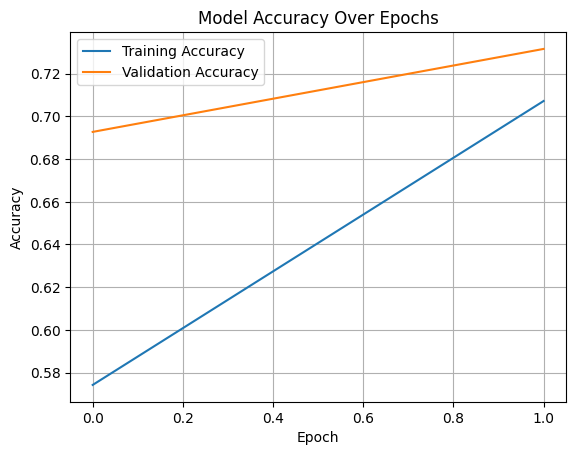

In [17]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model.load_weights("savedModels/bestCheckpoint-2.weights.h5")

ValueError: A total of 2 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(512,), Received: value.shape=(25088,). Target variable: <Variable path=batch_normalization/gamma, shape=(512,), dtype=float32, value=[0.2898383  0.66104746 0.7048832  0.32464314 0.63553286 0.825375
 0.6007578  0.71488124 0.07629783 0.2722593  0.43312597 0.38902527
 0.88342685 0.18381684 0.2017359  0.3568296  0.4483391  0.9281314
 0.20129375 0.49567086 0.63364196 0.55520064 0.03930735 0.2678278
 0.7250646  0.837965   0.6238698  0.7196336  0.34030437 0.5791671
 0.4590533  0.36967525 0.47545263 0.13962981 0.40107146 0.42655116
 0.76160544 0.844102   0.19124204 0.6104633  0.39793012 0.55569595
 0.3925465  0.45127773 0.48082045 0.32796058 0.2191965  0.5469043
 0.93746305 0.5520336  0.6673145  0.31943634 0.37015682 0.48605752
 0.8329399  0.42032078 0.23800464 0.421914   0.5324735  0.11392732
 0.57687646 0.14461845 0.37771454 0.40466762 0.28012878 0.52508134
 0.34682363 0.41000244 0.46464887 0.60074633 0.2642593  0.1948395
 0.1622053  0.4113046  0.7984109  0.6134208  0.50100666 0.18993367
 0.54063576 0.5477965  0.26495588 0.25842083 0.22687499 0.3189398
 0.52841973 0.6879836  0.8209878  0.66437143 0.06957793 0.7986433
 0.5524649  0.27337548 0.4146365  0.4305115  0.3206911  0.40142134
 0.5288844  0.35277742 0.48529342 0.5922509  0.523265   0.5049239
 0.43369135 0.14225937 0.41400647 0.47553003 0.34317002 0.27548656
 0.5659503  0.176265   0.5218298  0.4982805  0.80369675 0.3069906
 0.46358705 0.71780306 0.51824474 0.42635694 0.25977752 0.38940603
 0.7169465  0.49955863 0.19579607 0.4603743  0.9129137  0.16825242
 0.1479565  0.07929717 0.64220804 0.9569423  0.7921979  0.59006447
 0.5612791  0.6344335  0.16851068 0.18182516 0.36911225 0.5341074
 0.22901839 0.8947228  0.1102361  0.7969366  0.5548851  0.6081282
 0.8153781  0.37893188 0.5191899  0.9374807  0.41055343 0.394054
 0.35179856 0.694631   0.16927952 0.2164578  0.51377434 0.43351263
 0.4144125  0.31265035 0.7838895  0.7706034  0.9454342  0.19907206
 0.33218837 0.09567153 0.54301983 0.37612203 0.86396086 0.2844453
 0.83369255 0.14436248 0.44855443 0.28054386 0.958116   0.50642526
 0.5961764  0.48440546 0.4324574  0.3381704  0.34674355 0.2891151
 0.59583956 0.58557653 0.5753039  0.46142626 0.20391834 0.3118693
 0.45115727 0.7422497  0.13392045 0.44883835 0.1798632  0.29592323
 0.13221122 0.57323253 0.19703136 0.440042   0.3317743  0.36495897
 0.6760594  0.42572737 0.5696247  0.18542933 0.17881304 0.7163022
 0.4998838  0.8607026  0.25463086 0.5543942  0.40988    0.830058
 0.71339005 0.38517532 0.52234167 0.22938183 0.6349535  0.44633263
 0.30949402 0.49654192 0.5456257  0.75025207 0.25695813 0.40041998
 0.5543184  0.25148824 0.7363016  0.69259393 0.4381568  1.0384798
 0.54262125 0.8271464  0.24703453 0.24755353 0.24234547 0.41852617
 0.5720876  0.24966961 0.7196461  0.24542816 0.96834385 0.46861267
 0.50178844 0.43212283 0.3428775  0.64586556 0.3731879  0.507091
 0.5117362  0.19455512 0.47651392 0.9747924  0.19034177 0.19735716
 0.30358514 0.71508783 0.24796708 0.9066642  0.5522728  0.44423297
 0.27904445 0.37116915 0.5122773  0.42558718 0.5172227  0.9196503
 0.6398012  0.90582967 0.6429244  0.64164954 0.23485874 0.7060737
 0.22113374 0.42660218 0.755508   0.52375597 0.9949739  0.20032792
 0.53731215 0.92368495 0.8326296  0.3307879  0.3626777  0.31102663
 0.24494533 0.14693603 0.11065637 0.09190867 0.3791138  0.68145734
 0.5807538  0.30400178 0.52302283 0.4076849  0.54969496 0.32943144
 0.41312078 0.28080234 0.19684274 0.13612325 0.8556189  0.3514616
 0.08743228 0.46767557 0.6285403  0.22334595 0.36796063 0.3528374
 0.32726508 0.51578087 0.15305765 0.38019216 0.33367583 0.09281954
 0.52870876 0.43066525 0.52694327 0.47067067 0.3458087  0.13959564
 0.48132133 0.38470316 0.5681687  0.37474626 0.29670212 0.9349355
 0.08686828 0.42851436 0.9600715  0.31470782 0.5566492  0.36952883
 0.56611246 0.52583814 0.4488025  0.29685915 0.54051465 0.46415156
 0.3208679  0.57738984 0.2976049  0.5916766  0.4782319  0.4052751
 0.25117293 0.26870406 0.160043   0.6035078  0.5498511  0.47431648
 0.5400118  0.5028549  0.3592721  0.7649723  0.35337913 0.30224434
 0.22728857 0.6449684  0.80129784 0.33557907 0.40851715 0.2998704
 0.04368492 0.17607608 0.6621559  0.11439061 0.4615887  0.7510341
 0.5051989  0.38798338 0.51737297 0.24996981 0.80623263 0.56670725
 0.14318632 0.41636273 0.59035534 0.5169921  0.2986354  1.0234026
 0.2764094  0.38221166 0.31091475 0.5593154  1.0026338  0.6374084
 0.19515872 0.52891934 0.63098365 0.35901067 0.19207378 0.4352469
 0.49703047 0.77790385 0.20802593 0.5838744  0.21810725 0.46500772
 0.4965395  0.13404103 0.32799432 0.42908186 0.98972076 0.12800457
 0.5892741  0.4109148  0.4292087  0.32378387 0.19448985 0.5172199
 0.50225896 0.39211702 0.45159206 0.4354433  0.36160272 0.3661101
 0.7955351  0.17097281 0.35597605 0.37638032 0.32616106 0.3802208
 0.11182483 0.11762355 0.25020394 0.5745219  0.36563024 0.18181099
 0.5112247  0.4899742  0.77377284 0.10293499 0.46187228 0.43386143
 0.59403634 0.49138784 0.8013189  0.6203223  0.5152526  0.19817108
 0.3976817  0.34275195 0.3733574  0.79269004 0.59299827 0.5497335
 0.3911397  0.470348   0.57015693 0.4279505  0.99033684 0.19701697
 0.06110415 0.4124441  0.36776453 0.3581096  0.43406463 0.41945666
 0.7814655  0.26497033 0.37514994 0.4817689  0.58817726 0.14487475
 0.221231   0.5537942  0.38538766 0.4927419  0.35496056 0.2777148
 0.47612408 0.8823058  0.53728086 0.25247136 0.59599406 0.56287086
 0.20577475 0.37295747 0.1284364  0.5500934  0.47698066 0.41874897
 0.7907501  0.42188868 0.41042936 0.7522119  0.43147358 0.39242923
 0.45383716 0.45404294 0.32910126 0.4072992  0.58899456 0.1034599
 0.47131485 0.8125223  0.5916883  0.48678827 1.0431408  0.5829064
 0.92796504 0.5346023  0.69022346 0.6723729  0.28312635 0.21327178
 0.46205163 0.5850816  0.24292675 0.39404085 0.23339929 0.4346088
 0.42658812 0.45351   ]>

List of objects that could not be loaded:
[<BatchNormalization name=batch_normalization, built=True>, <Dense name=dense, built=True>]

In [ ]:
'''
model = tf.keras.models.load_model("vgg-16.keras")
model.load_weights("savedModels/model_at_epoch_1.h5")
model.summary()
'''

'\nmodel = tf.keras.models.load_model("vgg-16.keras")\nmodel.load_weights("savedModels/model_at_epoch_1.h5")\nmodel.summary()\n'

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
",".join(label_encoder.get_vocabulary()) 
len(label_encoder.get_vocabulary())

76

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
preds=model.predict(test_ds, verbose=1) # predict on the test data               

1833/1833 ━━━━━━━━━━━━━━━━━━━━ 337s 184ms/step


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

[np.str_('!'), np.str_('"'), np.str_('#'), np.str_('&'), np.str_("'"), np.str_('('), np.str_(')'), np.str_('*'), np.str_(','), np.str_('-'), np.str_('.'), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(':'), np.str_(';'), np.str_('?'), np.str_('A'), np.str_('B'), np.str_('C'), np.str_('D'), np.str_('E'), np.str_('F'), np.str_('G'), np.str_('H'), np.str_('I'), np.str_('J'), np.str_('K'), np.str_('L'), np.str_('M'), np.str_('N'), np.str_('O'), np.str_('P'), np.str_('Q'), np.str_('R'), np.str_('S'), np.str_('T'), np.str_('U'), np.str_('V'), np.str_('W'), np.str_('X'), np.str_('Y'), np.str_('Z'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.st

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
classes=label_encoder.get_vocabulary() # ordered list of class names

ytrue=[]
count = 0
print ("part 1")
l = len(images) - len(images) * (trainRatio + valRatio)
for images, label in tqdm(test_ds): 
    count += 1
    print (count/l*100,end="\r") #tqdm not working idk why
    for e in label:
        ytrue.append(e) # list of class names associated with each image file in test dataset 
ypred=[]
errors=0
count=0
l = len(preds)
print ("part 2")
for i, p in tqdm(enumerate(preds)):
    count +=1
    index=np.predict(p)# get probabilities of highest probabilities, if it is a letter, will include both upper and lower case
    
    klass=classes[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:    
        errors +=1
    
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '

print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)

# create a ` confusion matrix 


part 1
part 2203920351618745
there were 73467 correct predictions in 117288 tests for an accuracy of  62.64 % 


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

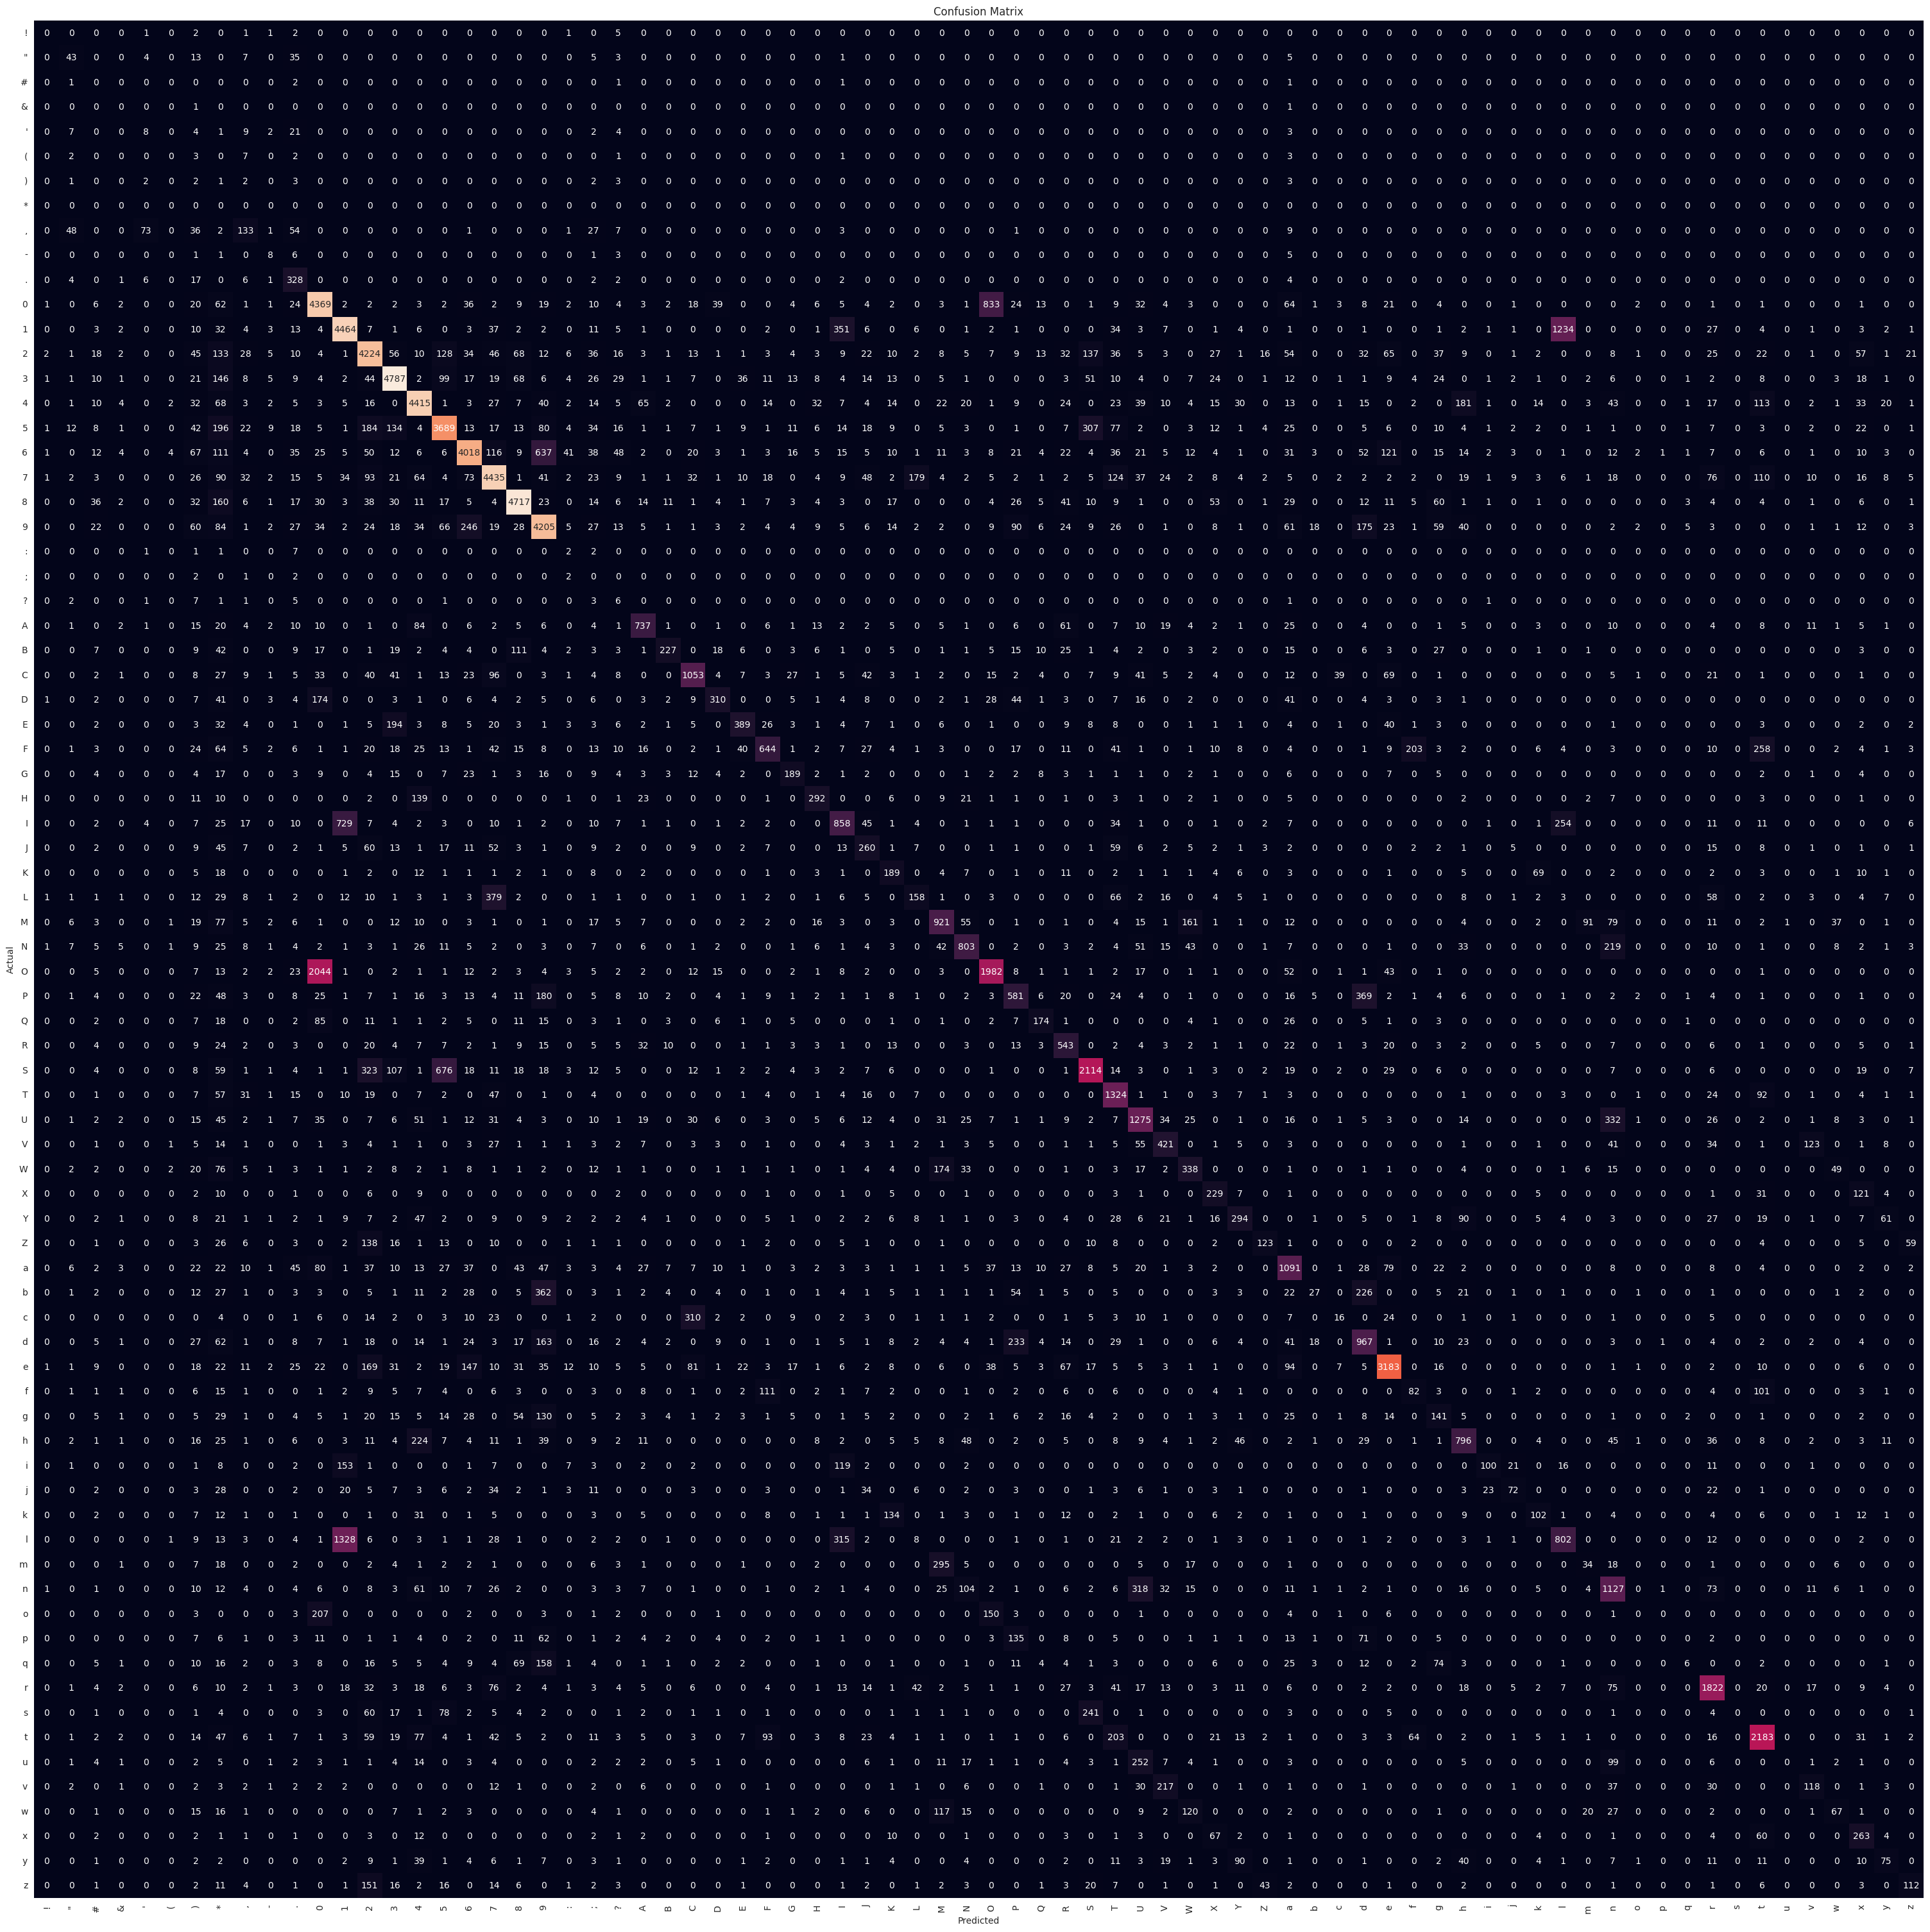

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
cm = confusion_matrix(ytrue, ypred )        
length=len(classes)
if length<8:
    fig_width=8
    fig_height=8
else:
    fig_width= int(length * .5)
    fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 